In [158]:
import base64
import collections
import datetime
import itertools
import json
import operator
import os
import pickle
import random
import re
import sys
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
#import PIL
import pylab
import scipy
#import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm
import xgboost as xgb

np.random.seed(1337)

%matplotlib inline

#sns.set(font_scale=1.0)
mpl.rcParams['figure.figsize'] = 10, 6
#sns.set_style('whitegrid')
#sns.set_palette(sns.color_palette('muted'))

# Categorizing and Tagging Text

## Using a Tagger

In [2]:
text = nltk.word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]

In [3]:
nltk.help.upenn_tagset('RB')

RB: adverb
    occasionally unabatingly maddeningly adventurously professedly
    stirringly prominently technologically magisterially predominately
    swiftly fiscally pitilessly ...


In [4]:
text = nltk.word_tokenize("They refuse to permit us to obtain the refuse permit")
nltk.pos_tag(text)

[('They', 'PRP'),
 ('refuse', 'VBP'),
 ('to', 'TO'),
 ('permit', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('obtain', 'VB'),
 ('the', 'DT'),
 ('refuse', 'NN'),
 ('permit', 'NN')]

In [5]:
text = nltk.Text(word.lower() for word in nltk.corpus.brown.words())
text.similar('woman')

man time day year car moment world family house country child boy
state job way war girl place word work


In [6]:
text.similar('bought')

made said put done seen had found left given heard brought got been
was set told took in felt that


In [7]:
text.similar('over')

in on to of and for with from at by that into as up out down through
is all about


In [8]:
text.similar('the')

a his this their its her an that our any all one these my in your no
some other and


## Tagged Corpora

### Representing Tagged Tokens

In [9]:
tagged_token = nltk.tag.str2tuple('fly/NN')
tagged_token

('fly', 'NN')

In [10]:
print tagged_token[0]
print tagged_token[1]

fly
NN


In [11]:
sent = '''
The/AT grand/JJ jury/NN commented/VBD on/IN a/AT number/NN of/IN
other/AP topics/NNS ,/, AMONG/IN them/PPO the/AT Atlanta/NP and/CC
Fulton/NP-tl County/NN-tl purchasing/VBG departments/NNS which/WDT it/PPS
said/VBD ``/`` ARE/BER well/QL operated/VBN and/CC follow/VB generally/RB
accepted/VBN practices/NNS which/WDT inure/VB to/IN the/AT best/JJT
interest/NN of/IN both/ABX governments/NNS ''/'' ./.'''
[nltk.tag.str2tuple(t) for t in sent.split()][:10]

[('The', 'AT'),
 ('grand', 'JJ'),
 ('jury', 'NN'),
 ('commented', 'VBD'),
 ('on', 'IN'),
 ('a', 'AT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('other', 'AP'),
 ('topics', 'NNS')]

### Reading Tagged Corpora

In [12]:
nltk.corpus.brown.tagged_words()

[(u'The', u'AT'), (u'Fulton', u'NP-TL'), ...]

In [13]:
print nltk.corpus.nps_chat.tagged_words()

[(u'now', 'RB'), (u'im', 'PRP'), (u'left', 'VBD'), ...]


In [14]:
nltk.corpus.conll2000.tagged_words()

[(u'Confidence', u'NN'), (u'in', u'IN'), ...]

In [15]:
nltk.corpus.treebank.tagged_words()

[(u'Pierre', u'NNP'), (u'Vinken', u'NNP'), ...]

In [16]:
# not all data sets have the same POS tags

print nltk.corpus.brown.tagged_words()
print nltk.corpus.treebank.tagged_words()

[(u'The', u'AT'), (u'Fulton', u'NP-TL'), ...]
[(u'Pierre', u'NNP'), (u'Vinken', u'NNP'), ...]


In [17]:
# there are foreign language data sets that are tagged

nltk.corpus.sinica_treebank.tagged_words()

[(u'\u4e00', u'Neu'), (u'\u53cb\u60c5', u'Nad'), ...]

In [18]:
# there are tagged sentences in some corpora

nltk.corpus.brown.tagged_sents()

[[(u'The', u'AT'), (u'Fulton', u'NP-TL'), (u'County', u'NN-TL'), (u'Grand', u'JJ-TL'), (u'Jury', u'NN-TL'), (u'said', u'VBD'), (u'Friday', u'NR'), (u'an', u'AT'), (u'investigation', u'NN'), (u'of', u'IN'), (u"Atlanta's", u'NP$'), (u'recent', u'JJ'), (u'primary', u'NN'), (u'election', u'NN'), (u'produced', u'VBD'), (u'``', u'``'), (u'no', u'AT'), (u'evidence', u'NN'), (u"''", u"''"), (u'that', u'CS'), (u'any', u'DTI'), (u'irregularities', u'NNS'), (u'took', u'VBD'), (u'place', u'NN'), (u'.', u'.')], [(u'The', u'AT'), (u'jury', u'NN'), (u'further', u'RBR'), (u'said', u'VBD'), (u'in', u'IN'), (u'term-end', u'NN'), (u'presentments', u'NNS'), (u'that', u'CS'), (u'the', u'AT'), (u'City', u'NN-TL'), (u'Executive', u'JJ-TL'), (u'Committee', u'NN-TL'), (u',', u','), (u'which', u'WDT'), (u'had', u'HVD'), (u'over-all', u'JJ'), (u'charge', u'NN'), (u'of', u'IN'), (u'the', u'AT'), (u'election', u'NN'), (u',', u','), (u'``', u'``'), (u'deserves', u'VBZ'), (u'the', u'AT'), (u'praise', u'NN'), (u'and'

In [19]:
brown_news_tagged = nltk.corpus.brown.tagged_words(categories='news')
tag_fd = nltk.FreqDist(tag.replace('$', 'S') for (word, tag) in brown_news_tagged)
tag_fd.most_common(10)

[(u'NN', 13162),
 (u'IN', 10616),
 (u'AT', 8893),
 (u'NP', 6866),
 (u'NNS', 5276),
 (u',', 5133),
 (u'.', 4452),
 (u'JJ', 4392),
 (u'CC', 2664),
 (u'VBD', 2524)]

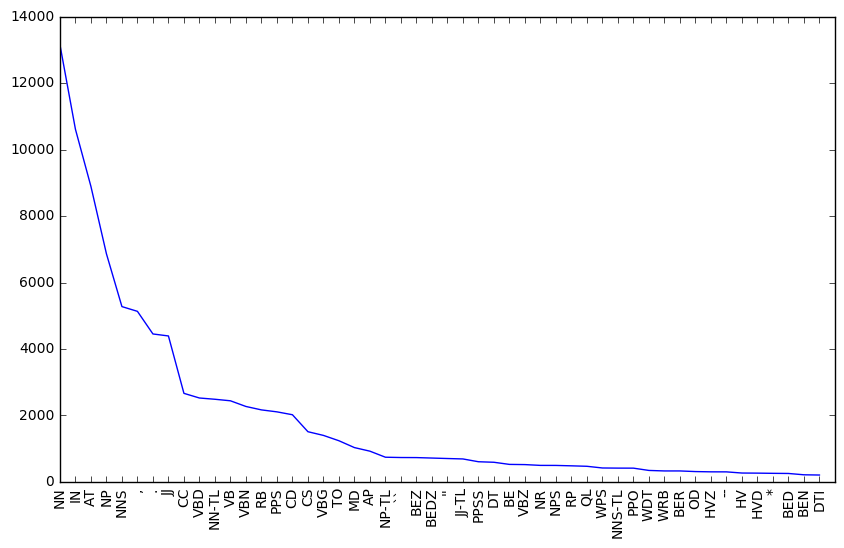

In [20]:
top_k = 50
tags = [tc[0] for tc in tag_fd.most_common(top_k)]
counts = [tc[1] for tc in tag_fd.most_common(top_k)]
plt.plot(counts)
_ = plt.xticks(range(top_k), tags, rotation='vertical')

### Nouns

In [24]:
word_tag_pairs = nltk.bigrams(brown_news_tagged)
nltk.FreqDist(a[1] for (a, b) in word_tag_pairs if b[1] == 'NN').most_common(10)

[(u'AT', 3982),
 (u'JJ', 2105),
 (u'NN', 1461),
 (u'IN', 1202),
 (u'PP$', 530),
 (u'DT', 311),
 (u'CC', 310),
 (u'AP', 307),
 (u'NP', 297),
 (u',', 258)]

### Verbs

In [27]:
wsj = nltk.corpus.treebank.tagged_words()
word_tag_fd = nltk.FreqDist(wsj)
[word + "/" + tag for (word, tag) in word_tag_fd if tag.startswith('V')][:10]

[u'attributes/VBZ',
 u'negotiated/VBN',
 u'failed/VBD',
 u'printed/VBN',
 u'sticking/VBG',
 u'close/VB',
 u'filed/VBN',
 u'teaches/VBZ',
 u'chooses/VBZ',
 u'suffer/VBP']

In [28]:
cfd1 = nltk.ConditionalFreqDist(wsj)
cfd1['yield'].keys()

[u'VB', u'NN']

In [29]:
cfd1['cut'].keys()

[u'VB', u'VBN', u'NN', u'VBD']

In [32]:
cfd2 = nltk.ConditionalFreqDist((tag, word) for (word, tag) in wsj)
cfd2['VB'].keys()[:10]

[u'represent',
 u'consider',
 u'copy',
 u'demand',
 u'focus',
 u'invent',
 u'sleep',
 u'Take',
 u'go',
 u'follow']

In [34]:
[w for w in cfd1.conditions() if 'VBD' in cfd1[w] and 'VBN' in cfd1[w]][:10]

[u'contributed',
 u'reported',
 u'brought',
 u'plunged',
 u'welcomed',
 u'assured',
 u'threatened',
 u'needed',
 u'nominated',
 u'rolled']

In [35]:
idx1 = wsj.index(('kicked', 'VBD'))
wsj[idx1-4:idx1+1]

[(u'While', u'IN'),
 (u'program', u'NN'),
 (u'trades', u'NNS'),
 (u'swiftly', u'RB'),
 (u'kicked', u'VBD')]

In [37]:
idx2 = wsj.index(('kicked', 'VBN'))
wsj[idx2-4:idx2+1]

[(u'head', u'NN'),
 (u'of', u'IN'),
 (u'state', u'NN'),
 (u'has', u'VBZ'),
 (u'kicked', u'VBN')]

### Unsimplified Tags

In [39]:
# Program to find the most frequent noun tags.

def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist(
        (tag, word) for (word, tag) in tagged_text if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].keys()[:5]) for tag in cfd.conditions())

tagdict = findtags('NN', nltk.corpus.brown.tagged_words(categories='hobbies'))
for tag in sorted(tagdict):
    print tag, tagdict[tag]

NN [u'valve', u'folklore', u'similarity', u'Night', u'yellow']
NN$ [u"editor's", u"pianist's", u"clown's", u"gasket's", u"mind's"]
NN$-HL [u"Drug's", u"drug's"]
NN$-TL [u"Star's", u"Class'", u"Executioner's", u"King's", u"Palace's"]
NN+BEZ [u"water's"]
NN+HVZ [u"guy's"]
NN-HL [u'Sheep', u'etiquette', u'no.', u'Compression', u'chain']
NN-TL [u'Breed', u'Poetry', u'Moon', u'Cooling', u'Station']
NN-TL-HL [u'Club', u'Port', u'Mosque', u'Champion', u'Show']
NNS [u'writings', u'hats', u'facilities', u'woods', u'$10.50']
NNS$ [u"composers'", u"beginners'", u"workers'", u"judges'", u"years'"]
NNS$-HL [u"Beginners'"]
NNS$-TL [u"Handlers'", u"Juniors'", u"Ladies'", u"Children's", u"Veterans'"]
NNS-HL [u'operations', u'Sheep', u'rifles', u'sales', u'barbecues']
NNS-TL [u'Gables', u'Stands', u'Bafflers', u'Heights', u'Polychemicals']
NNS-TL-HL [u'Notes', u'Juniors']


### Exploring Tagged Corpora

In [43]:
brown_learned_text = nltk.corpus.brown.words(categories='learned')
sorted(set(b for (a, b) in nltk.bigrams(brown_learned_text) if a == 'often'))[:10]

[u',',
 u'.',
 u'accomplished',
 u'analytically',
 u'appear',
 u'apt',
 u'associated',
 u'assuming',
 u'became',
 u'become']

In [45]:
brown_lrnd_tagged = nltk.corpus.brown.tagged_words(categories='learned')
tags = [b[1] for (a, b) in nltk.bigrams(brown_lrnd_tagged) if a[0] == 'often']
fd = nltk.FreqDist(tags)
fd.tabulate()

VBN  VB VBD  JJ  IN  RB   ,  CS  QL WRB  TO VBG BEN  HV QLP  AP  RP   . VBZ 
 15  10   8   5   4   3   3   3   3   1   1   1   1   1   1   1   1   1   1 


In [49]:
# Searching for three-word phrases using POS tags.

def process(sentence):
    for (w1,t1), (w2,t2), (w3,t3) in nltk.trigrams(sentence):
        if (t1.startswith('V') and t2 == 'TO' and t3.startswith('V')):
            print w1, w2, w3
            
for tagged_sent in nltk.corpus.brown.tagged_sents()[:100]:
    process(tagged_sent)

combined to achieve
continue to place
serve to protect
wanted to wait
allowed to place
expected to become
expected to approve
expected to make
intends to make
seek to set
like to see


In [56]:
# Finally, let’s look for words that are highly ambiguous as to their part-of-speech
# tag. Understanding why such words are tagged as they are in each context can help us
# clarify the distinctions between the tags.

brown_news_tagged = nltk.corpus.brown.tagged_words(categories='news')
data = nltk.ConditionalFreqDist((word.lower(), tag) for (word, tag) in brown_news_tagged)
    
for word in data.conditions()[:1000]:
    if len(data[word]) > 3:
        tags = data[word].keys()
        print word, ' '.join(tags)

second OD-TL OD RB NN QL
place NP VB NN-TL NN
fair JJ-HL JJ-TL NN-TL NN JJ
best VB JJT NP-TL RBT JJT-HL
right RB JJ NN QL
for CS IN-TL IN-HL RB IN
ballet FW-NN NN-TL NN FW-NN-TL
red NP NN-TL JJ-TL JJ


## Automatic Tagging

In [82]:
brown_tagged_sents = nltk.corpus.brown.tagged_sents(categories='news')
brown_sents = nltk.corpus.brown.sents(categories='news')
brown_tagged_words = nltk.corpus.brown.tagged_words(categories='news')
brown_words = nltk.corpus.brown.words(categories='news')

### The Default Tagger

In [60]:
# The simplest possible tagger assigns the same tag to each token.

tags = [tag for (word, tag) in nltk.corpus.brown.tagged_words(categories='news')]
nltk.FreqDist(tags).max()

u'NN'

In [62]:
raw = 'I do not like green eggs and ham, I do not like them Sam I am!'
tokens = nltk.word_tokenize(raw)
default_tagger = nltk.DefaultTagger('NN')
default_tagger.tag(tokens)[:10]

[('I', 'NN'),
 ('do', 'NN'),
 ('not', 'NN'),
 ('like', 'NN'),
 ('green', 'NN'),
 ('eggs', 'NN'),
 ('and', 'NN'),
 ('ham', 'NN'),
 (',', 'NN'),
 ('I', 'NN')]

In [63]:
default_tagger.evaluate(brown_tagged_sents)

0.13089484257215028

### The Regular Expression Tagger

In [66]:
# The regular expression tagger assigns tags to tokens on the basis of matching patterns.

patterns = [
(r'.*ing$', 'VBG'),
(r'.*ed$', 'VBD'),
(r'.*es$', 'VBZ'),
(r'.*ould$', 'MD'),
(r'.*\'s$', 'NN$'),
(r'.*s$', 'NNS'),
(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),
(r'.*', 'NN')]

regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.tag(brown_sents[3])[:10]

[(u'``', 'NN'),
 (u'Only', 'NN'),
 (u'a', 'NN'),
 (u'relative', 'NN'),
 (u'handful', 'NN'),
 (u'of', 'NN'),
 (u'such', 'NN'),
 (u'reports', 'NNS'),
 (u'was', 'NNS'),
 (u'received', 'VBD')]

In [67]:
regexp_tagger.evaluate(brown_tagged_sents)

0.20326391789486245

### The Lookup Tagger

In [107]:
fd = nltk.FreqDist(nltk.corpus.brown.words(categories='news'))
cfd = nltk.ConditionalFreqDist(nltk.corpus.brown.tagged_words(categories='news'))
most_freq_words = [tf[0] for tf in fd.most_common(100)]
likely_tags = dict((word, cfd[word].max()) for word in most_freq_words)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
baseline_tagger.evaluate(brown_tagged_sents)

0.45578495136941344

In [108]:
sent = nltk.corpus.brown.sents(categories='news')[3]
baseline_tagger.tag(sent)[:10]

[(u'``', u'``'),
 (u'Only', None),
 (u'a', u'AT'),
 (u'relative', None),
 (u'handful', None),
 (u'of', u'IN'),
 (u'such', None),
 (u'reports', None),
 (u'was', u'BEDZ'),
 (u'received', None)]

In [109]:
baseline_tagger = nltk.UnigramTagger(model=likely_tags, backoff=nltk.DefaultTagger('NN'))

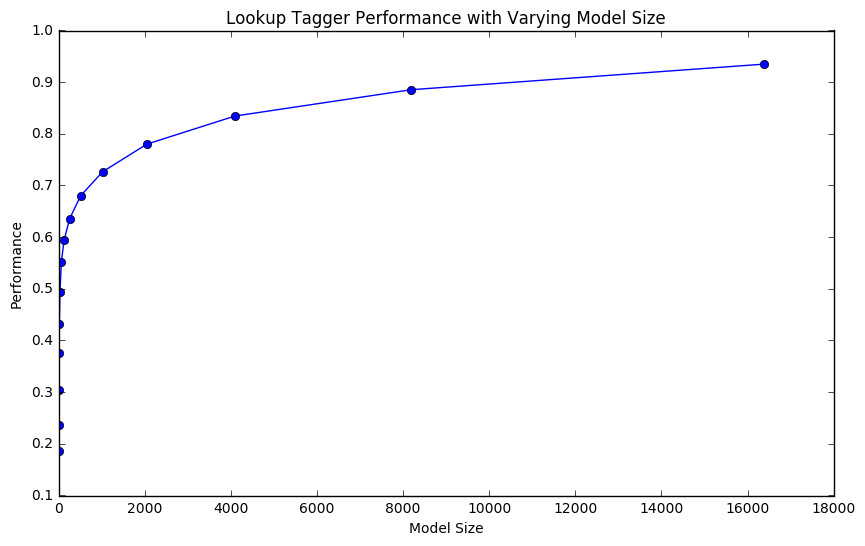

In [114]:
def performance(cfd, wordlist):
    lt = dict((word, cfd[word].max()) for word in wordlist)
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger('NN'))
    return baseline_tagger.evaluate(nltk.corpus.brown.tagged_sents(categories='news'))

def display():
    words_by_freq = list([tf[0] for tf in nltk.FreqDist(nltk.corpus.brown.words(categories='news')).most_common()])
    cfd = nltk.ConditionalFreqDist(nltk.corpus.brown.tagged_words(categories='news'))
    sizes = 2 ** pylab.arange(15)
    perfs = [performance(cfd, words_by_freq[:size]) for size in sizes]
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()
    
display()

## N-Gram Tagging

### Unigram Tagging

In [116]:
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents)
unigram_tagger.tag(brown_sents[2007])[:10]

[(u'Various', u'JJ'),
 (u'of', u'IN'),
 (u'the', u'AT'),
 (u'apartments', u'NNS'),
 (u'are', u'BER'),
 (u'of', u'IN'),
 (u'the', u'AT'),
 (u'terrace', u'NN'),
 (u'type', u'NN'),
 (u',', u',')]

In [117]:
unigram_tagger.evaluate(brown_tagged_sents)

0.9349006503968017

### Separating the Training and Testing Data

In [118]:
size = int(len(brown_tagged_sents) * 0.9)
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
unigram_tagger = nltk.UnigramTagger(train_sents)
unigram_tagger.evaluate(test_sents)

0.8120203329014253

### General N-Gram Tagging

In [119]:
bigram_tagger = nltk.BigramTagger(train_sents)
bigram_tagger.tag(brown_sents[2007])[:10]

[(u'Various', u'JJ'),
 (u'of', u'IN'),
 (u'the', u'AT'),
 (u'apartments', u'NNS'),
 (u'are', u'BER'),
 (u'of', u'IN'),
 (u'the', u'AT'),
 (u'terrace', u'NN'),
 (u'type', u'NN'),
 (u',', u',')]

In [121]:
unseen_sent = brown_sents[4203]
bigram_tagger.tag(unseen_sent)[:10]

[(u'The', u'AT'),
 (u'population', u'NN'),
 (u'of', u'IN'),
 (u'the', u'AT'),
 (u'Congo', u'NP'),
 (u'is', u'BEZ'),
 (u'13.5', None),
 (u'million', None),
 (u',', None),
 (u'divided', None)]

In [122]:
bigram_tagger.evaluate(test_sents)

0.10276088906608193

### Combining Taggers

In [123]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t2.evaluate(test_sents)

0.844911791089405

In [127]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, cutoff=5, backoff=t1)
t2.evaluate(test_sents)

0.8406259344164257

In [128]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t3 = nltk.TrigramTagger(train_sents, cutoff=3, backoff=t2)
t3.evaluate(test_sents)

0.8437157380643875

### Tagging Unknown Words

In [ ]:
# Our approach to tagging unknown words still uses backoff to a regular expression
# tagger or a default tagger. These are unable to make use of context. Thus, if our
# tagger encountered the word blog, not seen during training, it would assign it the
# same tag, regardless of whether this word appeared in the context the blog or to
# blog. How can we do better with these unknown words, or out-of-vocabulary items?

# A useful method to tag unknown words based on context is to limit the vocabulary of
# a tagger to the most frequent n words, and to replace every other word with a special
# word UNK using the method shown in Section 5.3. During training, a unigram tagger will
# probably learn that UNK is usually a noun. However, the n-gram taggers will detect
# contexts in which it has some other tag. For example, if the preceding word is to
# (tagged TO), then UNK will probably be tagged as a verb.

### Tagging Across Sentence Boundaries

In [129]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t2.evaluate(test_sents)

0.844911791089405

## Exercises

In [153]:
# Which nouns are more common in their plural form, rather than their singular form?
# (Only consider regular plurals, formed with the -s suffix.)

tws = zip(
    nltk.corpus.brown.words(),
    [tw[1] for tw in nltk.corpus.brown.tagged_words()])

fd = nltk.FreqDist([tw[0].lower() for tw in tws if tw[1] == 'NN'])

for k in fd.keys():
    if k.endswith('s') and k[:-1] in fd.keys() and fd[k] > fd[k[:-1]]:
        print k

headquarters
ethics
us
rdws
means
biceps
metaphysics
gas
barracks


In [161]:
# Which word has the greatest number of distinct tags? What are they, and what do they represent?

tags = collections.defaultdict(set)

for (w, t) in nltk.corpus.brown.tagged_words():
    tags[w].add(t)
    
tag_counts = [(w, len(tags[w])) for w in tags.keys()]

tag_counts.sort(key=operator.itemgetter(1), reverse=True)

print tag_counts[0]
print tags[tag_counts[0][0]]

(u'that', 12)
set([u'CS-NC', u'DT-NC', u'NIL', u'WPS-NC', u'CS-HL', u'WPO-NC', u'WPS', u'WPS-HL', u'WPO', u'CS', u'DT', u'QL'])


In [167]:
# What proportion of word types are always assigned the same part-of-speech tag?

print 1.0 * sum(tc[1] == 1 for tc in tag_counts) / len(tag_counts)

0.844283497155


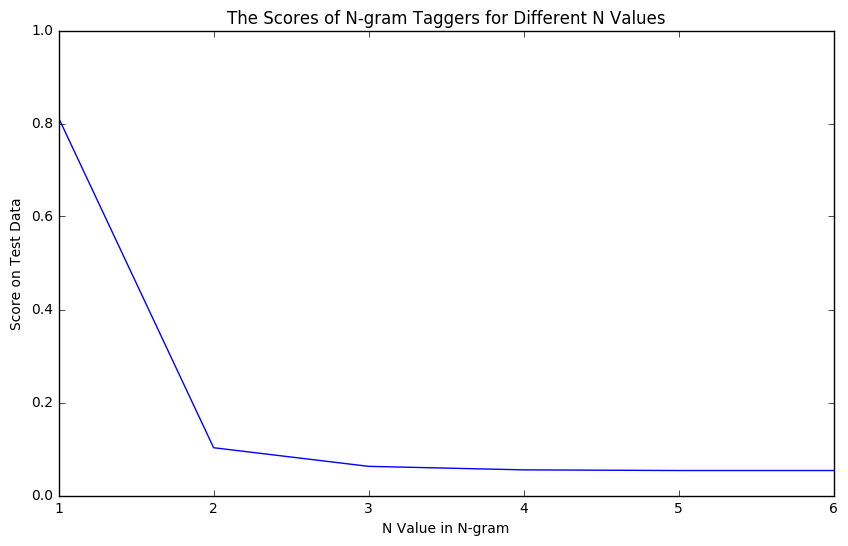

In [179]:
# How serious is the sparse data problem? Investigate the performance of n-gram taggers as n
# increases from 1 to 6. Tabulate the accuracy score. Estimate the training data required for
# these taggers, assuming a vocabulary size of 10^5 and a tagset size of 10^2.

scores = [None]
for i in range(1, 7):
    tagger = nltk.NgramTagger(train=train_sents, n=i)
    scores.append(tagger.evaluate(test_sents))
    
plt.plot(scores)
_ = plt.xticks(range(1, 7))
_ = plt.xlim((1, 6))
_ = plt.ylim((0, 1))
_ = plt.xlabel('N Value in N-gram')
_ = plt.ylabel('Score on Test Data')
_ = plt.title('The Scores of N-gram Taggers for Different N Values')

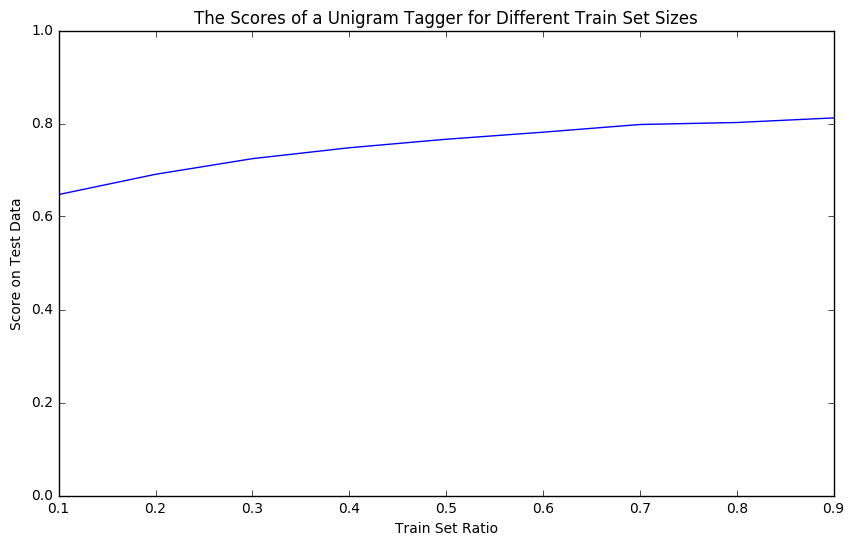

In [188]:
# Plot the performance curve for a unigram tagger, as the amount of training data is varied.

scores = [None]
for i in range(1, 10):
    size = int(len(brown_tagged_sents) * (1.0 * i / 10))
    train_sents = brown_tagged_sents[:size]
    test_sents = brown_tagged_sents[size:]
    unigram_tagger = nltk.UnigramTagger(train_sents)
    scores.append(unigram_tagger.evaluate(test_sents))
    #print unigram_tagger.evaluate(test_sents)
    
plt.plot(scores)
_ = plt.xticks(range(1, 10), ['{0:2.1f}'.format(1.0 * i / 10) for i in range(1, 10)])
_ = plt.xlim((1, 9))
_ = plt.ylim((0, 1))
_ = plt.xlabel('Train Set Ratio')
_ = plt.ylabel('Score on Test Data')
_ = plt.title('The Scores of a Unigram Tagger for Different Train Set Sizes')